In [23]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

In [24]:
image_size = (180, 180)
batch_size = 4

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "img",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 49 files belonging to 4 classes.
Using 40 files for training.
Using 9 files for validation.


In [25]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

2024-10-08 15:31:54.966847: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 4 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

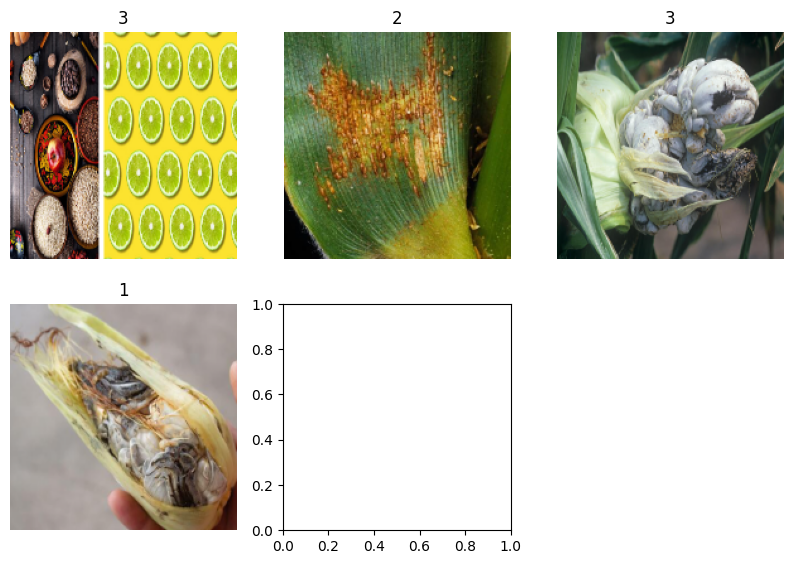

In [26]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [27]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


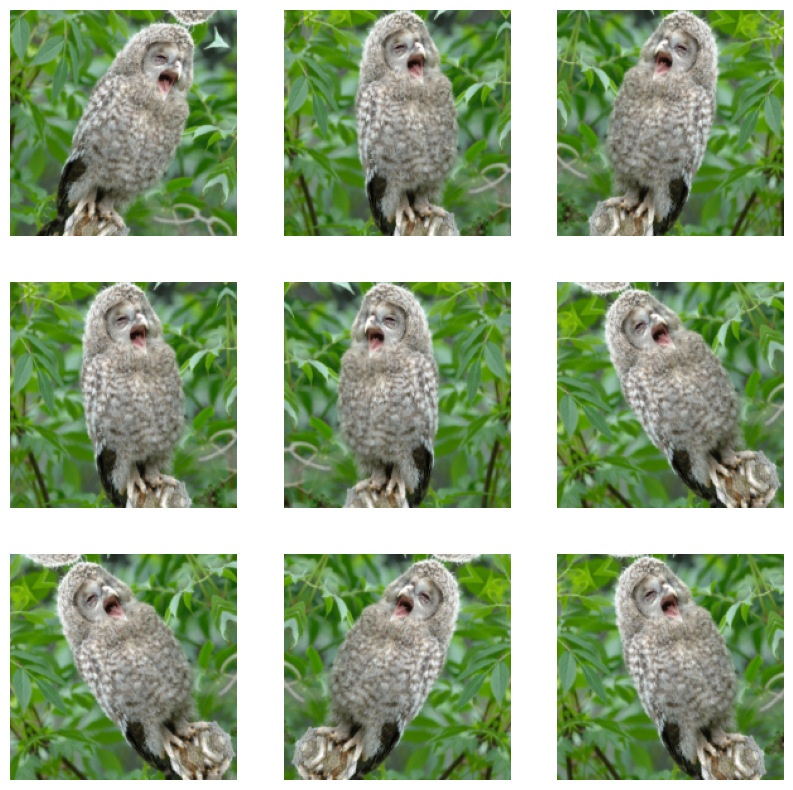

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


In [29]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [30]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
epochs = 25

# callbacks = [
#     keras.callbacks.ModelCheckpoint("models/save_at_{epoch}.keras"),
# ]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "models/best_model.keras", save_best_only=True, monitor="val_acc", mode="max"
    ),
]

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 516ms/step - acc: 0.2776 - loss: 1.0986 - val_acc: 0.0000e+00 - val_loss: 0.6292
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step - acc: 0.2740 - loss: -1.0067 - val_acc: 0.0000e+00 - val_loss: 0.5398
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - acc: 0.2634 - loss: -2.7749 - val_acc: 0.0000e+00 - val_loss: 0.4179
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 489ms/step - acc: 0.3538 - loss: -2.5615 - val_acc: 0.0000e+00 - val_loss: 0.2616
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - acc: 0.3203 - loss: -5.0137 - val_acc: 0.0000e+00 - val_loss: 0.1097
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 475ms/step - acc: 0.2930 - loss: -7.9414 - val_acc: 0.0000e+00 - val_loss: -0.0691
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step - acc: 0.3647 - loss: -7.9009 - val_acc: 0.1111 - val_loss: -0.2488
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 488ms/step - acc: 0.2567 - loss: -9.6616 - val_acc: 0.1111 - val_loss: -0.4424
Epoch 9/25
10/10 ━━━━━

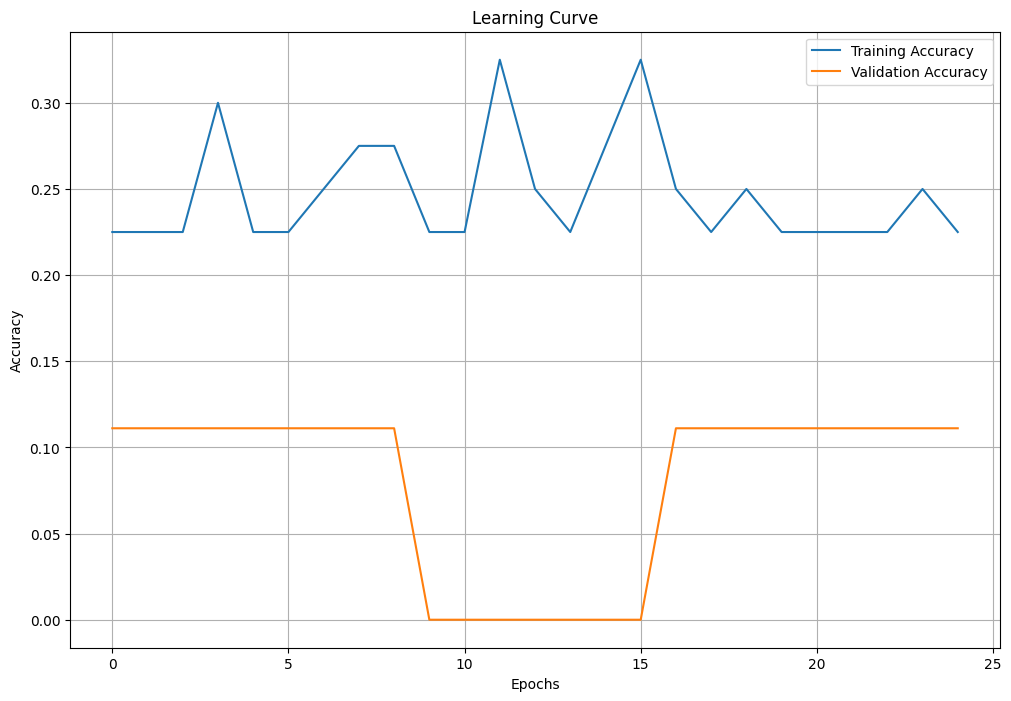

In [13]:
# Plot the learning curve
plt.figure(figsize=(12, 8))
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


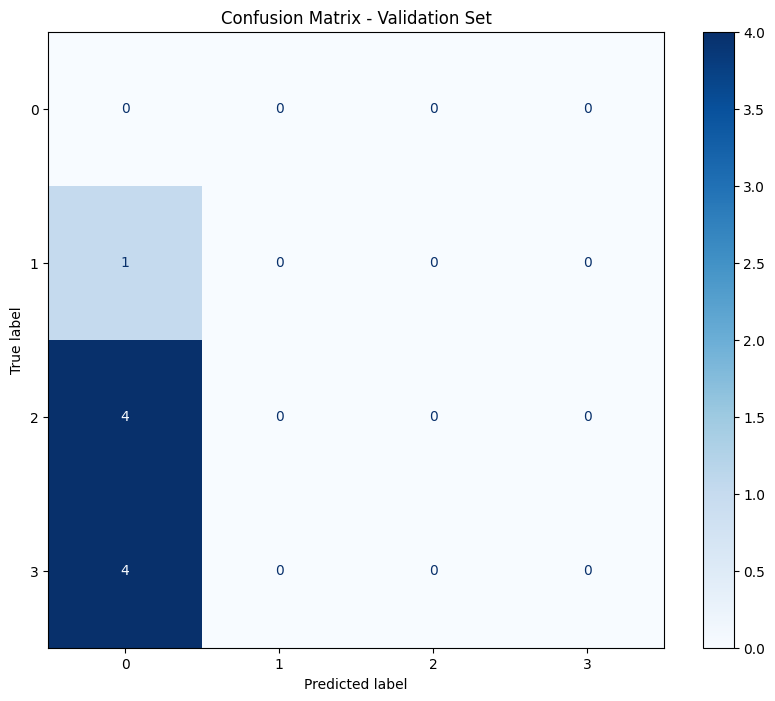

In [19]:
# Make predictions on the validation dataset
val_predictions = model.predict(val_ds)
val_pred_labels = tf.argmax(val_predictions, axis=1)

# Get the true labels from the validation dataset
val_true_labels = tf.concat([y for x, y in val_ds], axis=0)

# Compute the confusion matrix
val_cm = confusion_matrix(val_true_labels, val_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix - Validation Set')
plt.show()

In [21]:
    # Faire les prédictions sur le jeu de validation
    val_predictions = model.predict(val_ds)
    val_pred_labels = tf.argmax(val_predictions, axis=1)

    # Calculer le nombre total de prédictions par catégorie
    total_per_category = tf.math.bincount(val_true_labels, minlength=4)

    # Calculer le nombre de prédictions correctes par catégorie
    correct_per_category = tf.math.bincount(val_true_labels * tf.cast(val_true_labels == val_pred_labels, tf.int32), minlength=4)

    # Calculer le pourcentage de réussite et d'échec par catégorie
    success_percentage = (correct_per_category / total_per_category) * 100
    failure_percentage = 100 - success_percentage

    # Afficher les résultats
    for category in range(4):
        print(f"Catégorie {category}:")
        print(f"  Pourcentage de réussite: {success_percentage[category]:.2f}%")
        print(f"  Pourcentage d'échec: {failure_percentage[category]:.2f}%")
        # Tracer un histogramme avec le pourcentage du modèle sur chaque classe
        categories = range(4)
        plt.figure(figsize=(10, 6))
        plt.bar(categories, success_percentage.numpy(), color='g', alpha=0.6, label='Pourcentage de réussite')
        plt.bar(categories, failure_percentage.numpy(), bottom=success_percentage.numpy(), color='r', alpha=0.6, label='Pourcentage d\'échec')
        plt.xlabel('Catégories')
        plt.ylabel('Pourcentage')
        plt.title('Pourcentage de réussite et d\'échec par catégorie')
        plt.legend()
        plt.show()

InvalidArgumentError: cannot compute Equal as input #1(zero-based) was expected to be a int32 tensor but is a int64 tensor [Op:Equal] name: 